## DNN Compression Demo

This tutorial will walk through training a neural compressor for lossy compression of images. The code below is based on PyTorch for instantiating neural network models as well as automatic differentiation.

Make sure you are running on GPU: Runtime --> Change runtime type --> Hardware Accelerator --> GPU

In [1]:
# """Run this cell for environment setup."""
# !git clone https://github.com/leieric/dnn-compression-demo.git
# !cp dnn-compression-demo/entropy_model.py .
# !pip install torchac
# !pip install ninja

In [23]:
%load_ext autoreload
%autoreload 2

"""Import pytorch and other packages"""
import torch
from torchvision import transforms, datasets
import torchvision
import matplotlib.pyplot as plt
from entropy_model import EntropyBottleneck
import tqdm
import torchac
import sys

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

"""Some data handling functions"""
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 2, 2, 2 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def plot_image(x_tensor):
    plt.figure(figsize=(2, 2))
    plt.imshow(invTrans(x_tensor).permute(1,2,0))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

We will use SVHN (street view house numbers) dataset, and split into train/test datasets.

In [3]:
dset = datasets.SVHN(root='data/', download=True, transform=transform)
train_len = int(0.7*len(dset))
train_dset, test_dset = torch.utils.data.random_split(dset, [train_len, len(dset)-train_len])

182041600it [00:08, 22375207.79it/s]                               


Use pytorch dataloader for batch processing.

In [4]:
loader = torch.utils.data.DataLoader(train_dset, batch_size=128, num_workers=2, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=128, num_workers=2, pin_memory=True)

Plot some SVHN images.

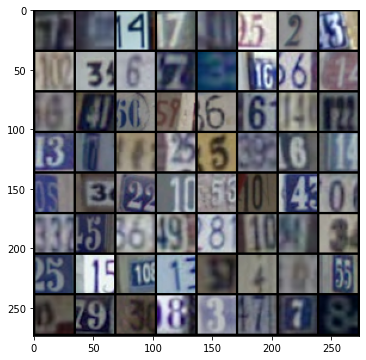

In [5]:
it = iter(loader)
x, _ = next(it)
x = torchvision.utils.make_grid(invTrans(x[0:64]))

plt.figure(figsize=(6,6))
plt.imshow(x.permute(1,2,0))
plt.show()

##Models

First, define Encoder neural network. 
In the forward() function, it will map images $X$ to latent features $Z$, via
a series of convolution layers and ReLU nonlinearities.

In [6]:
class Encoder(torch.nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Encoder, self).__init__()

        self.img_size = img_size

        self.image_to_features = torch.nn.Sequential(
            torch.nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            torch.nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        z = self.image_to_features(x)
        return z

Next, define Decoder neural network. 
In the forward() function, it will map quantized $Z$ to reconstructed images $\hat{X}$, via
a series of transpose convolution layers and ReLU nonlinearities.
The final output passes through Tanh nonlinearity in order to normalize pixels in $[-1, 1]$.


In [7]:
class Decoder(torch.nn.Module):
    def __init__(self, img_size, dim):
        super(Decoder, self).__init__()
        self.dim = dim
        self.img_size = img_size
        self.features_to_image = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(2 * dim),
            torch.nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(dim),
            torch.nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            torch.nn.Tanh()
        )

    def forward(self, z_tilde):
        x_hat = self.features_to_image(z_tilde)
        return x_hat

Lastly, we define the AutoencoderCompressor, which uses the Encoder and Decoder.
It also uses the EntropyBottleneck layer which takes in a latent feature $z$, and outputs its quantized version $\tilde{z}$, as well as its likelihoods $p_{\tilde{z}}(\tilde{z})$. 

The EntropyBottleneck layer is complex, so we will not go over all the details of its implementation (it resides in a separate file). In summary, it uses a *factorized prior*, meaning that it assumes the components to be independent. Hence, it just needs to model a single univariate density, which can be used to estimate the likelihoods of the entire quantized vector $\tilde{z}$. 

During training, we estimate the rate by adding uniform noise as a stand-in for quantization and computing the average negative log likelihood. During evaluation, we use hard quantization, and pass the quantized symbols (and likelihoods) to an arithmetic encoder.

In [40]:
class AutoencoderCompressor(torch.nn.Module):
    def __init__(self, bottleneck_dim=32, img_size=(32, 32, 3), dim=16):
        super(AutoencoderCompressor, self).__init__()
        self.encoder = Encoder(img_size, dim)
        self.decoder = Decoder(img_size, dim)
        self.bottleneck_dim = bottleneck_dim
        self.entropy_bottleneck = EntropyBottleneck(bottleneck_dim)
    
    def forward(self, x):
        z = self.encoder(x)
        z_tilde, likelihood = self.entropy_bottleneck(z) # use uniform noise during training, hard quantization during eval
        x_hat = self.decoder(z_tilde)
        return x_hat, likelihood

    """At evaluation time, compress() will apply hard quantization and arithmetic encoding."""
    @torch.no_grad()
    def compress(self, x):
        z = self.encoder(x)

        # apply hard quantization
        z_tilde = self.entropy_bottleneck._quantize(z, mode="symbols")

        # get the support of the quantized distribution
        min_v = z_tilde.min().detach().float()
        max_v = z_tilde.max().detach().float()
        symbols = torch.arange(min_v, max_v+1)
        symbols = symbols.reshape(-1, 1, 1, 1).repeat(z_tilde.shape[0], z_tilde.shape[1], z_tilde.shape[2], z_tilde.shape[3])# (num_symbols, channels)

        # Normalize the quantized samples.
        z_tilde = z_tilde - min_v
        min_v, max_v = torch.tensor([min_v]), torch.tensor([max_v])
        z_tilde = z_tilde.to(torch.int16)

        # get PMF of discrete quantized distribution over the support
        pmf = self.entropy_bottleneck._likelihood(symbols)
        pmf = torch.clamp(pmf, min=self.entropy_bottleneck._likelihood_bound)

        # Convert PMF to CDF
        cdf = self.entropy_bottleneck._pmf_to_cdf(pmf)
        cdf = cdf.permute(1,2,3,0).unsqueeze(0).repeat(z_tilde.shape[0], 1, 1, 1, 1).detach().cpu()
        # Call arithmetic encoding
        strings = torchac.encode_float_cdf(cdf, z_tilde.cpu(), check_input_bounds=True)

        return strings, min_v.cpu().numpy(), max_v.cpu().numpy()


    """Arithmetic decoding."""
    @torch.no_grad()
    def decompress(self, strings, min_v, max_v, latent_shape):
        # z_tilde = self.entropy_bottleneck.decompress(strings, min_v, max_v, shape)

        # get symbols
        symbols = torch.arange(min_v, max_v+1)
        symbols = symbols.reshape(-1, 1, 1, 1).repeat(latent_shape[0], latent_shape[1], latent_shape[2], latent_shape[3])

        # get pmf
        pmf = self.entropy_bottleneck._likelihood(symbols)
        pmf = torch.clamp(pmf, min=self.entropy_bottleneck._likelihood_bound)
        # pmf = pmf.permute(1,0, 2, 3)
        # get cdf
        cdf = self.entropy_bottleneck._pmf_to_cdf(pmf)
        # arithmetic decoding
        out_cdf = cdf.permute(1,2,3,0).unsqueeze(0).repeat(latent_shape[0], 1, 1, 1, 1).detach().cpu()
        z_tilde = torchac.decode_float_cdf(out_cdf, strings)
        z_tilde = z_tilde.float()
        z_tilde += min_v

        x_hat = self.decoder(z_tilde)
        return x_hat


## Loss functions

For the rate, it is defined as $R = \mathbb{E}_X[-\log_2 p_{\tilde{z}}(\tilde{z})]$.

For the distortion, it is defined as $D = \mathbb{E}_X[\|X-\hat{X}\|_2^2]$.

In [41]:
"""
Define a rate loss, which is defined as the average information of the model.
"""
def rate_loss(likelihoods):
    batch_size = likelihoods.shape[0]
    rate_batch = -torch.sum(torch.log2(likelihoods)) # total rate of batch (factorized prior)
    rate_per_sample = rate_batch / batch_size # rate per sample
    return rate_per_sample

"""
Define a distortion loss, which is squared-error distortion on the images.
"""
def distortion_loss(x, x_hat):
    # SED = squared-error-distortion
    SED_batch = torch.linalg.vector_norm(x-x_hat, dim=(1,2,3))**2 # vector of SED for each element in batch
    SED_per_sample = torch.mean(SED_batch)
    return SED_per_sample

## Training 

train_one_epoch() will go through the entire dataset once, updating gradients
of the model for every batch of samples that it processes. 
The loss function we optimize is $R + \lambda D$, the joint rate-distortion loss.

In [42]:
def train_one_epoch(model, optimizer, loader, lmbda):
    model.train()
    
    rate_epoch, distortion_epoch = 0, 0
    for x, _ in loader:
        
        x = x.to(device) # Send batch to the GPU.
        optimizer.zero_grad()  # Clear gradients.
        x_hat, likelihoods = model(x)  # Forward pass through the model.
        rate = rate_loss(likelihoods) # compute average rate.
        distortion = distortion_loss(x, x_hat) # compute average distortion.
        RD_loss = rate + lmbda * distortion # compute loss function.
        RD_loss.backward()  # Backward pass (backpropagate gradients through model).
        optimizer.step()  # Update model parameters.

        rate_epoch += rate.item()
        distortion_epoch += distortion.item()

    return rate_epoch / len(loader), distortion_epoch / len(loader)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data.cuda()
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

In [43]:
"""
Define the model, and choose Adam as the optimization algorithm, with learning rate 1e-3.
"""
model = AutoencoderCompressor(bottleneck_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [44]:
"""
Set lmbda, the rate-distortion tradeoff parameter, and begin training.
"""
lmbda=10.
for epoch in range(1, 11):
    r, d = train_one_epoch(model, optimizer, loader, lmbda=lmbda)
    # test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, rate: {r:.4f} bps, distortion: {d:.4f}')

Epoch: 01, rate: 2211.5021 bps, distortion: 90.6843
Epoch: 02, rate: 544.7297 bps, distortion: 33.1154
Epoch: 03, rate: 374.6120 bps, distortion: 27.9898
Epoch: 04, rate: 325.0898 bps, distortion: 26.3393
Epoch: 05, rate: 301.9393 bps, distortion: 25.3998
Epoch: 06, rate: 288.1090 bps, distortion: 24.7103
Epoch: 07, rate: 279.4416 bps, distortion: 24.3145
Epoch: 08, rate: 273.4066 bps, distortion: 24.6207
Epoch: 09, rate: 268.9494 bps, distortion: 24.3027
Epoch: 10, rate: 265.8401 bps, distortion: 23.6225


## Evaluating Trained Compressor

In [53]:
"""Sample 8 test images"""
it = iter(test_loader)
x,_ = next(it)
x = x[0:8]
model = model.to('cpu')

In [54]:
"""Compress the images using arithmetic encoding of the quantized latent variables."""
strings, min_v, max_v = model.compress(x) # Call the AutoencoderCompressor's compress() function, which applies arithmetic coding
bits = bin(int.from_bytes(strings, sys.byteorder)) # convert byte string to bitstring
print(f'Bitstring: {bits[2:]}')
print(f'Avg bits per image: {len(bits) / len(x)}')

Bitstring: 11101110000010111001011110011010110101011111010101000111100011110011110111111001100111101111010100010000011011011111100000111010010001110011110100001100000100110110111010001000110011001100010110110011100101100001111000111000111101110100000001111111010000101110100110001001001101011010100101110100001001101001101100101000001110001110001101100110001011000001001011111100000100100010000000011101011000000010001111111010010010101101011011001100110011001101101110010101111101011100110100011001101010011011000010110101110101111101100011101001001110000110001001000010101010000011110100101001111100011000101101010011000101101101010100111111100001011101111100011111111111001000011101100101100100101111011101000001110110110010010000110010101001010010110110110010100010011000000110000001100101011100101101110011000011000100110101000000010000100000001010100110111000001111111101001000110011110101001101111010010011111110110100100110011110111010101111110100011001010010001000100100110111000100000000010

In [55]:
"""Decompress the bits to the reconstructed images."""
latent_shape = (8, 64, 4, 4)
x_hat = model.decompress(strings, min_v[0], max_v[0], latent_shape) # call AutoencoderCompressor's decompress() function, which applies arithmetic decoding
print(f'Avg distortion per image: {distortion_loss(x, x_hat):.3f}')

Avg distortion per image: 21.728


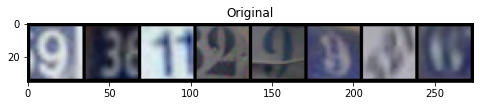

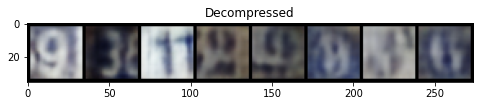

Avg. rate=228.25, Avg. distortion=21.728


In [56]:
"""Plot the original and reconstructed images."""
x_grid = torchvision.utils.make_grid(invTrans(x)).cpu().detach()
x_hat_grid = torchvision.utils.make_grid(invTrans(x_hat)).cpu().detach()

plt.figure(figsize=(8,4))
plt.imshow(x_grid.permute(1,2,0))
plt.title('Original')
plt.show()

plt.figure(figsize=(8,4))
plt.imshow(x_hat_grid.permute(1,2,0))
plt.title('Decompressed')
plt.show()

print(f'Avg. rate={len(bits) / len(x)}, Avg. distortion={distortion_loss(x, x_hat):.3f}')